In [ ]:
import os
import numpy as np
import torch
import clip
import decord
from PIL import Image
from tqdm import tqdm

config = {
    "video_dir": "charades/videos",  # Folder containing your videos
    "output_dir": "charades_clip_features_zero_shot",  # Output folder for extracted features
    "clip_model": "ViT-B/32",
    "frame_interval": 1.0,  # Seconds between sampled frames (adjust as needed)
    "batch_size": 16,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

os.makedirs(config["output_dir"], exist_ok=True)

# Initialize CLIP
model, preprocess = clip.load(config["clip_model"], device=config["device"])
model.eval()

def extract_video_features(video_path, frame_interval_sec=1.0):
    """
    Extract CLIP features from a video by sampling frames at a fixed interval (in seconds).
    Aggregates the features by averaging over all sampled frames.
    """
    try:
        # Open video with decord
        vr = decord.VideoReader(video_path)
        fps = vr.get_avg_fps()
        total_frames = len(vr)
        
        # Calculate step size (in frames) based on desired frame_interval_sec
        step = int(fps * frame_interval_sec)
        if step < 1:
            step = 1
        
        # Generate indices for sampled frames
        frame_indices = np.arange(0, total_frames, step, dtype=int)
        frames = vr.get_batch(frame_indices).asnumpy()
        
        # Process frames using CLIP preprocess
        processed_frames = []
        for frame in frames:
            img = Image.fromarray(frame)
            processed = preprocess(img).unsqueeze(0).to(config["device"])
            processed_frames.append(processed)
        
        # Batch processing to get features
        features = []
        for i in range(0, len(processed_frames), config["batch_size"]):
            batch = torch.cat(processed_frames[i:i+config["batch_size"]], dim=0)
            with torch.no_grad():
                batch_features = model.encode_image(batch).cpu().numpy()
                features.append(batch_features)
                
        # Concatenate and aggregate features (e.g. average)
        features = np.concatenate(features, axis=0)
        video_feature = features.mean(axis=0)
        return video_feature
    
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return None

def process_videos():
    video_files = [f for f in os.listdir(config["video_dir"]) if f.endswith(".mp4")]
    for video_file in tqdm(video_files, desc="Processing videos"):
        video_path = os.path.join(config["video_dir"], video_file)
        output_file = os.path.join(config["output_dir"], f"{os.path.splitext(video_file)[0]}.npz")
        if os.path.exists(output_file):
            continue
        video_feature = extract_video_features(video_path, config["frame_interval"])
        if video_feature is not None:
            np.savez(output_file, feature=video_feature)

if __name__ == "__main__":
    process_videos()

Processing videos: 100%|█████████████████████████████████████████████████████████| 9848/9848 [2:11:59<00:00,  1.24it/s]


In [33]:
import os
import numpy as np
import unittest

# Configuration (should match your extraction script's output directory)
config = {
    "output_dir": "charades_clip_features_zero_shot",
    "clip_model": "ViT-B/32",  # Ensure this matches the model you used
}

class TestSavedCLIPFeatures(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        """Check if the output directory exists and if there are any saved feature files."""
        cls.output_dir = config["output_dir"]
        if not os.path.exists(cls.output_dir):
            raise FileNotFoundError(f"Output directory not found: {cls.output_dir}")
        cls.feature_files = [f for f in os.listdir(cls.output_dir) if f.endswith(".npz")]
        if not cls.feature_files:
            raise FileNotFoundError(f"No .npz feature files found in: {cls.output_dir}")
        cls.clip_feature_dim = 512 if config["clip_model"] == "ViT-B/32" else None # Update if using a different CLIP model

    def test_saved_files_exist(self):
        """Check if there are any saved feature files."""
        self.assertGreater(len(self.feature_files), 0, f"No .npz files found in {self.output_dir}")

    def test_saved_file_extension(self):
        """Check if all saved files have the .npz extension."""
        for file_name in self.feature_files:
            self.assertTrue(file_name.endswith(".npz"), f"File {file_name} does not have the .npz extension.")

    def test_saved_feature_shape(self):
        """Check if the loaded features have the expected shape."""
        if self.clip_feature_dim is None:
            self.skipTest("CLIP feature dimension not defined for the current model. Skipping shape check.")

        for file_name in self.feature_files:
            file_path = os.path.join(self.output_dir, file_name)
            try:
                with np.load(file_path) as data:
                    self.assertIn('feature', data, f"File {file_name} does not contain a 'feature' key.")
                    feature = data['feature']
                    self.assertEqual(feature.shape, (self.clip_feature_dim,),
                                     f"Feature in {file_name} has shape {feature.shape}, expected {(self.clip_feature_dim,)}")
            except Exception as e:
                self.fail(f"Error loading or checking shape of {file_name}: {e}")

    def test_saved_feature_dtype(self):
        """Check if the saved features have the expected data type (float16)."""
        expected_dtype = np.float16  # Updated to expect float16
        for file_name in self.feature_files:
            file_path = os.path.join(self.output_dir, file_name)
            try:
                with np.load(file_path) as data:
                    if 'feature' in data:
                        feature = data['feature']
                        self.assertEqual(feature.dtype, expected_dtype,
                                         f"Feature in {file_name} has dtype {feature.dtype}, expected {expected_dtype}")
            except Exception as e:
                self.fail(f"Error loading or checking dtype of {file_name}: {e}")

    def test_saved_feature_not_all_zeros(self):
        """Check if the saved features are not all zeros (indicating a potential issue)."""
        for file_name in self.feature_files:
            file_path = os.path.join(self.output_dir, file_name)
            try:
                with np.load(file_path) as data:
                    if 'feature' in data:
                        feature = data['feature']
                        self.assertFalse(np.allclose(feature, np.zeros_like(feature)),
                                         f"Feature in {file_name} is all zeros, which might indicate an error.")
            except Exception as e:
                self.fail(f"Error loading or checking zero values in {file_name}: {e}")

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 91.478s

OK


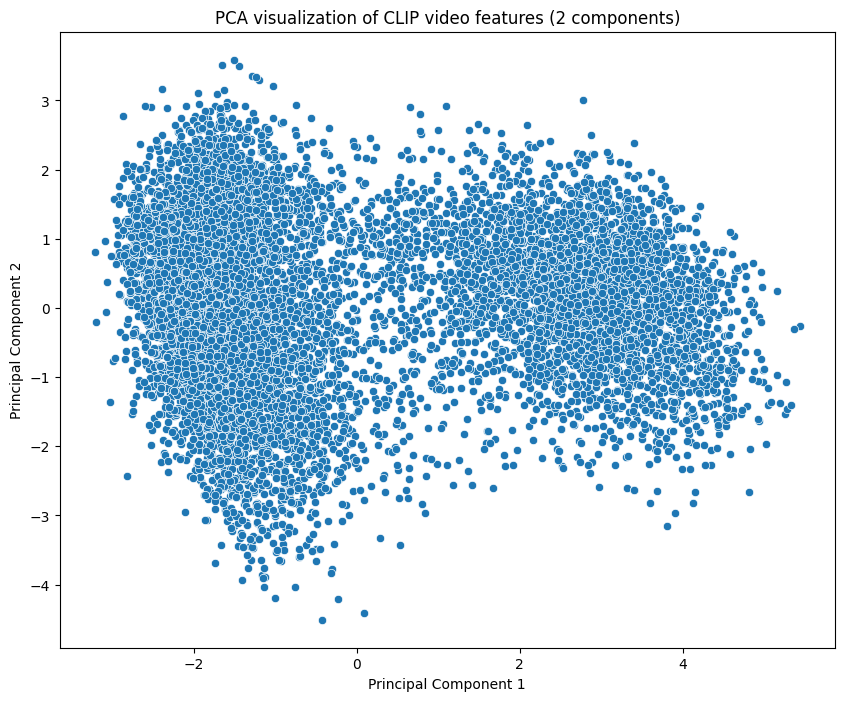

In [36]:
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

feature_dir = "charades_clip_features_zero_shot"
video_features = []
video_ids = []
# Load your features
for filename in os.listdir(feature_dir):
    if filename.endswith(".npz"):
        video_id = filename[:-4]
        with np.load(os.path.join(feature_dir, filename)) as data:
            video_features.append(data['feature'])
            video_ids.append(video_id)

if not video_features:
    print(f"No features found in {feature_dir}")
else:
    feature_matrix = np.array(video_features)

    # Apply PCA for dimensionality reduction (e.g., to 2 components)
    n_components = 2
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(feature_matrix)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1])
    plt.title(f"PCA visualization of CLIP video features ({n_components} components)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    # Optional: Add annotations for a subset of video IDs
    # for i, txt in enumerate(video_ids[:50]): # Example for the first 50 videos
    #     plt.annotate(txt, (reduced_features[i, 0], reduced_features[i, 1]))

    plt.show()